<a href="https://colab.research.google.com/github/TrueCactus/Projet_Netflix/blob/master/Projet_Jetflix_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projet Netflix**

---

Le but de ce notebook est de créer un modèle de machine learning permettant de 
suggèrer à un utilisateurs des films à partir de son film préféré.
Pour cela, nous utiliserons un dataset comprenant des films et leurs caractéristiques comme les acteurs, l'intrigue ou encore le budget, par exemple.

Le Nettoyage du Dataset a été réalisé en amont de ce notebook.



# Connexion à la Base SQL  et import des tables 

Une base de Données SQL a été créée permettant d'héberger les trois tables nécessaire au projet.
La Table Movie qui contient les informations sur les films et leurs caractéristiques.
La Table Acteur, issu du traitement de la table Movie, qui contient des informations sur les acteurs comme leur nombre d'apparition , le genre des films dans lequel ils ont joué.
La Table User qui contient les informations sur les utilisateurs de la fonction de recommandation de film.

![base de donnée](https://i.imgur.com/8qTuADX.jpg)

In [0]:
#@title MotdePasse { display-mode: "both" }


import pandas as pd
import mysql.connector


motdepasse = "?" #@param {type:"string"}

#Initialisation de la connexion
cnx = mysql.connector.connect(user='root', password=motdepass,host='127.0.0.1',database='jeflix')

#selection des différentes tables qui seront utiliséées
dataActeur=pd.read_sql('select * from dataacteur', cnx)
dataUser=pd.read_sql('select * from datauser', cnx)
dataMovie=pd.read_sql('select*from datamovie',cnx)


# Import des Dataset , directement via fichier CSV

In [0]:
import pandas as pd

In [0]:
DataMovie=pd.read_csv("/content/XCOPY.csv") #import du dataset "Films"

In [0]:
ListeCols=['color',
       'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes','Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western', 'color_ Black and White', 'color_Color',
       'content_rating_Approved', 'content_rating_G', 'content_rating_GP',
       'content_rating_M', 'content_rating_NC-17', 'content_rating_Not Rated',
       'content_rating_PG', 'content_rating_PG-13', 'content_rating_Passed',
       'content_rating_R', 'content_rating_TV-14', 'content_rating_Unrated',
       'content_rating_X']

In [0]:
DataMovie=DataMovie[ListeCols]

In [0]:
DataMovie.to_csv("DataMovieNetflix.csv")

In [0]:
ActeurDataFrame=pd.read_csv("/content/ActeurDataFrame.csv") #Import du Dataset "Acteur"

In [0]:
ActeurDataFrame.rename(columns={'key_0':'Name'}, inplace=True)

In [0]:
ActeurDataFrame= ActeurDataFrame.iloc[:,1:]

In [0]:
ActeurDataFrame.head()

# Modèle non supervisé de clustering pour créér groupe d'acteur :

Afin d'utiliser une variable relative aux acteurs dans le modèle de suggestion final, les acteurs sont regroupés en différentes catégories. Ces catégories sont
définies par un modèle de machine learning non supervisé de clustering : AgglomerativeClustering.

En amont de ce notebook, le même exercice a été réalisé avec un modèle de K-Means.

In [0]:
from sklearn.cluster import AgglomerativeClustering
#instanciation du model :
cluster = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward')

In [0]:
# Ajustement du modèle et Prédiction :
cluster.fit_predict(ActeurDataFrame.iloc[:,1:-1])

In [0]:
# Création de la Colonne Grp ACH pour assigner le groupe de l'acteur :
ActeurDataFrame['GroupCluster']=cluster.fit_predict(ActeurDataFrame.iloc[:,1:-1])

# Ajout des cats acteurs dans le DataMovie

In [0]:
DataMovie[['actor_1_name','actor_2_name','actor_3_name']] 

In [0]:
#fonction pour assigner à chaque acteur sa catégorie issu du K-MEANS ( réalisé en amont du notebook):
def CatActeur (Nom) :
    for i in ActeurDataFrame['Name'] :
        if i == Nom :
           if ActeurDataFrame['Grp'][ActeurDataFrame['Name']==i].empty == False :
              Cat=ActeurDataFrame['Grp'][ActeurDataFrame['Name']==i]
              return Cat.values[0]
           else :
             return none
           
     

In [0]:
#assigner à chaque acteur sa catégorie :
DataMovie["Cat_Acteur_1"]=DataMovie['actor_1_name'].apply(lambda X : CatActeur(X))
DataMovie["Cat_Acteur_2"]=DataMovie['actor_2_name'].apply(lambda X : CatActeur(X))
DataMovie["Cat_Acteur_3"]=DataMovie['actor_3_name'].apply(lambda X : CatActeur(X))

In [0]:
DataMovie[["Cat_Acteur_1", "actor_1_name","Cat_Acteur_2", "actor_2_name","Cat_Acteur_3", "actor_3_name"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4661 entries, 0 to 4660
Data columns (total 6 columns):
Cat_Acteur_1    4654 non-null float64
actor_1_name    4654 non-null object
Cat_Acteur_2    4653 non-null float64
actor_2_name    4653 non-null object
Cat_Acteur_3    4647 non-null float64
actor_3_name    4647 non-null object
dtypes: float64(3), object(3)
memory usage: 218.6+ KB


#Traitement des Plot Key Words 


Les mots de l'intrigue "Plot Key Words" sont traités afin d'être utilisés dans le modèle de suggestion final.

 Les "Plot Key Word" sont traités avec les outils de NLP ( Natural Language Processing) et vectorisés afin d'être intégrés au modèle de machine learning.

In [0]:
pip install --user -U nltk

     |████████████████████████████████| 1.5MB 4.7MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449908 sha256=be62133c84be885b87d0a480424e824c61d6fe14e56d91ef207c59a30593c54a
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk


In [0]:
#import des différentes librairies utilisées.
import nltk
nltk.download('popular')
#pour le tokenizer
from nltk.tokenize import word_tokenize, sent_tokenize
#pour les distributions
from nltk.probability import FreqDist
#les stopwords english
nltk.download('stopwords')
from nltk.corpus import stopwords
#le stemming
from nltk.stem import PorterStemmer
#le lemmatizer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [0]:
DataMovie['plot_keywords']

0                  avatar future marine native paraplegic
1       goddess marriage ceremony marriage proposal pi...
2                     bomb espionage sequel spy terrorist
3       deception imprisonment lawlessness police offi...
4       alien american civil war male nipple mars prin...
                              ...                        
4656                   assassin death guitar gun mariachi
4657          jewell mongol nostradamus stepnicka vallone
4658                  written and directed by cast member
4659               fraud postal worker prison theft trial
4660    actress name in title crush date four word tit...
Name: plot_keywords, Length: 4661, dtype: object

In [0]:
#supression des mots stops :
stop_word = set(stopwords.words('english'))
def StopWordFct(x) :
    filtered_sentence=[]
    for w in x : 
       if w.lower() not in stop_word: 
        filtered_sentence.append(w) 
    return filtered_sentence

In [0]:
# Transformation en liste de mot :
DataMovie['plot_keywords'].iloc[1].split(" ")

['goddess',
 'marriage',
 'ceremony',
 'marriage',
 'proposal',
 'pirate',
 'singapore']

In [0]:
#application de la fonction split suivie de StopWordFct()
DataMovie['Plot_Key_Words_StopWords']=DataMovie['plot_keywords'].map(lambda x : StopWordFct(x.split(" ") ))

In [0]:
DataMovie[['plot_keywords','Plot_Key_Words_StopWords']]

,plot_keywords,Plot_Key_Words_StopWords
0,avatar future marine native paraplegic,"[avatar, future, marine, native, paraplegic]"
1,goddess marriage ceremony marriage proposal pi...,"[goddess, marriage, ceremony, marriage, propos..."
2,bomb espionage sequel spy terrorist,"[bomb, espionage, sequel, spy, terrorist]"
3,deception imprisonment lawlessness police offi...,"[deception, imprisonment, lawlessness, police,..."
4,alien american civil war male nipple mars prin...,"[alien, american, civil, war, male, nipple, ma..."
...,...,...
4656,assassin death guitar gun mariachi,"[assassin, death, guitar, gun, mariachi]"
4657,jewell mongol nostradamus stepnicka vallone,"[jewell, mongol, nostradamus, stepnicka, vallone]"
4658,written and directed by cast member,"[written, directed, cast, member]"
4659,fraud postal worker prison theft trial,"[fraud, postal, worker, prison, theft, trial]"


In [0]:
#Le processus de « lemmatisation » consiste à représenter les mots (ou « lemmes » ) sous leur forme canonique.
# Par exemple un verbe conjugué sera remplacé par l'infinitif.
Lemma=WordNetLemmatizer() # instanciation du modèle de lemmatization

In [0]:
#fonction pour lemmatiser les mots d'une liste de mots
def Lemmatisation (X) :
  Resultat=[Lemma.lemmatize(i) for i in X ]
  return Resultat

In [0]:
#Application de la fonction Lemmatisation sur la colonne traitée avec les Stop words
DataMovie['Plot_Key_Words_StopWords_Lemma']=DataMovie['Plot_Key_Words_StopWords'].map(lambda x: Lemmatisation(x))

In [0]:
#résultats
DataMovie[['plot_keywords','Plot_Key_Words_StopWords','Plot_Key_Words_StopWords_Lemma']]

,plot_keywords,Plot_Key_Words_StopWords,Plot_Key_Words_StopWords_Lemma
0,avatar future marine native paraplegic,"[avatar, future, marine, native, paraplegic]","[avatar, future, marine, native, paraplegic]"
1,goddess marriage ceremony marriage proposal pi...,"[goddess, marriage, ceremony, marriage, propos...","[goddess, marriage, ceremony, marriage, propos..."
2,bomb espionage sequel spy terrorist,"[bomb, espionage, sequel, spy, terrorist]","[bomb, espionage, sequel, spy, terrorist]"
3,deception imprisonment lawlessness police offi...,"[deception, imprisonment, lawlessness, police,...","[deception, imprisonment, lawlessness, police,..."
4,alien american civil war male nipple mars prin...,"[alien, american, civil, war, male, nipple, ma...","[alien, american, civil, war, male, nipple, ma..."
...,...,...,...
4656,assassin death guitar gun mariachi,"[assassin, death, guitar, gun, mariachi]","[assassin, death, guitar, gun, mariachi]"
4657,jewell mongol nostradamus stepnicka vallone,"[jewell, mongol, nostradamus, stepnicka, vallone]","[jewell, mongol, nostradamus, stepnicka, vallone]"
4658,written and directed by cast member,"[written, directed, cast, member]","[written, directed, cast, member]"
4659,fraud postal worker prison theft trial,"[fraud, postal, worker, prison, theft, trial]","[fraud, postal, worker, prison, theft, trial]"


In [0]:
#Transformation en texte.
DataMovie['Plot_Key_Words_StopWords_Lemma_Join']= DataMovie['Plot_Key_Words_StopWords_Lemma'].apply(lambda x : (" ".join(x)))

In [0]:
DataMovie['Plot_Key_Words_StopWords_Lemma_Join']

0                  avatar future marine native paraplegic
1       goddess marriage ceremony marriage proposal pi...
2                     bomb espionage sequel spy terrorist
3       deception imprisonment lawlessness police offi...
4       alien american civil war male nipple mar princess
                              ...                        
4656                   assassin death guitar gun mariachi
4657          jewell mongol nostradamus stepnicka vallone
4658                         written directed cast member
4659               fraud postal worker prison theft trial
4660    actress name title crush date four word title ...
Name: Plot_Key_Words_StopWords_Lemma_Join, Length: 4661, dtype: object

## Visualisation en Nuage de 

Afin de visualiser les mots dont la fréquence est la plus importante dans les intrigues de films, un nuage de mot est réalisé.

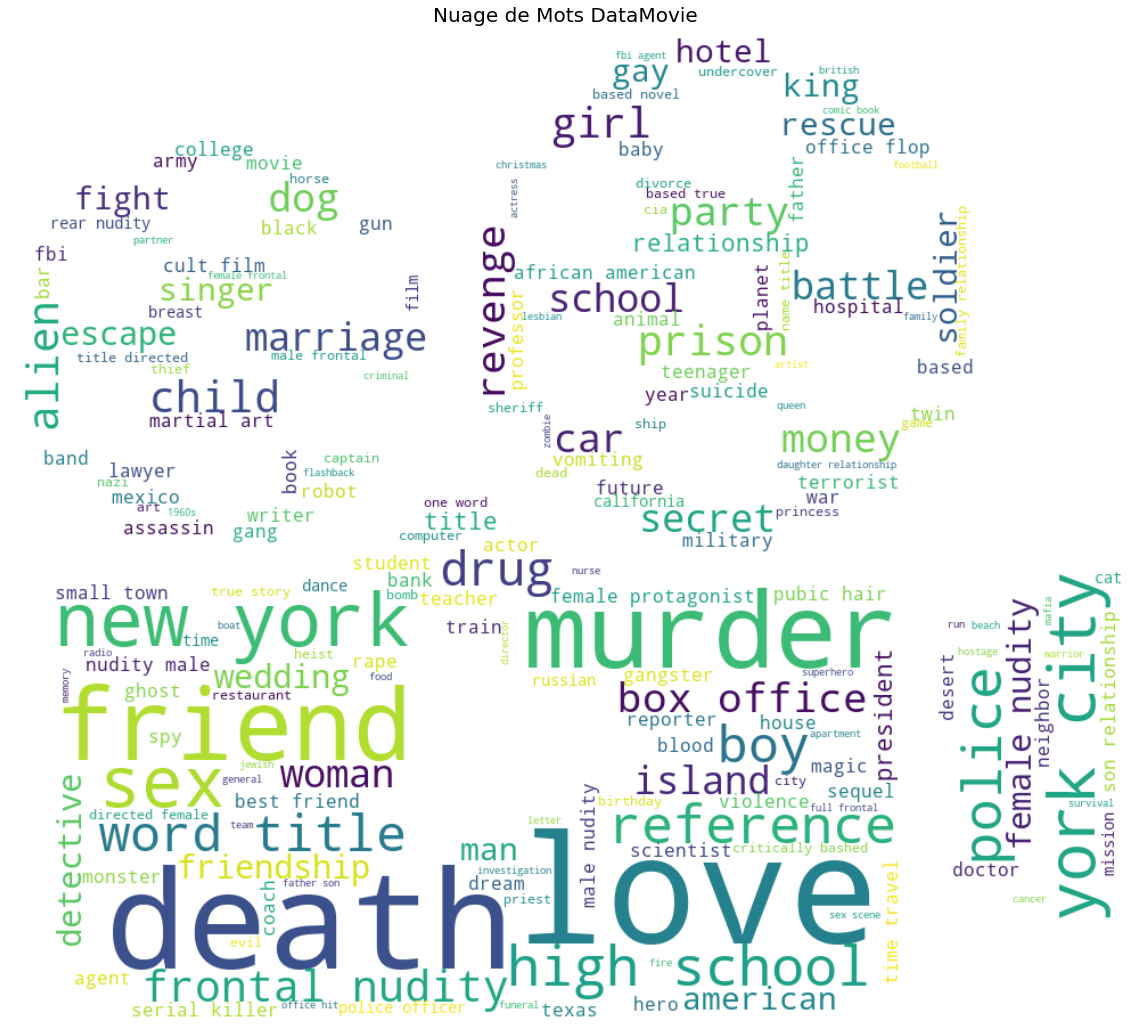

In [0]:
#visualisation en nuage de mots afin de visualiser les mots qui ressortent le plus des intrigues.
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from urllib.request import urlopen

#creation d'un masque pour avoir un nuage de mots en forme de caméra
wave_mask = np.array(Image.open(urlopen("https://icon-library.net/images/film-icon/film-icon-0.jpg")))


nuagedemot=WordCloud(mask=wave_mask,width=3000, height=3000,margin=0,background_color='white').generate((" ").join(DataMovie['Plot_Key_Words_StopWords_Lemma_Join']))

fig=plt.figure(figsize=(20,20))
plt.imshow(nuagedemot, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de Mots DataMovie",fontsize=20)
plt.show()

In [0]:
#Frequence d'apparition des mots et mise en évidence des 20 mots les plus importants.
FrequenceMotSPIMPORTANT=FreqDist((" ").join(DataMovie['Plot_Key_Words_StopWords_Lemma_Join']).split())
FrequenceMotSPIMPORTANT.most_common(20)
Dico=dict(FrequenceMotSPIMPORTANT.most_common(20))
Mots_Importants_20=sorted(Dico, key=Dico.get,reverse=True)[0:20]
Mots_Importants_20

['female',
 'title',
 'nudity',
 'love',
 'friend',
 'school',
 'male',
 'relationship',
 'police',
 'sex',
 'death',
 'new',
 'murder',
 'york',
 'based',
 'city',
 'drug',
 'high',
 'girl',
 'film']

## Vectorisation avec CountVectorizer

In [0]:
#Afin d'utiliser les mots de l'intrigue comme variables des modèles de machine learning, ils sont vectorisés
from sklearn.feature_extraction.text import CountVectorizer
# Instanciation du modèle et ajustement
vectorizer = CountVectorizer()
vectorizer.fit(DataMovie['Plot_Key_Words_StopWords_Lemma_Join'])
# vocabulaire
print(vectorizer.vocabulary_)
# vectorisation des plot_key_words
vector = vectorizer.transform(DataMovie['Plot_Key_Words_StopWords_Lemma_Join'])


{'avatar': 428, 'future': 2140, 'marine': 3203, 'native': 3522, 'paraplegic': 3802, 'goddess': 2233, 'marriage': 3210, 'ceremony': 944, 'proposal': 4136, 'pirate': 3939, 'singapore': 4755, 'bomb': 655, 'espionage': 1827, 'sequel': 4635, 'spy': 4943, 'terrorist': 5258, 'deception': 1438, 'imprisonment': 2637, 'lawlessness': 2966, 'police': 3995, 'officer': 3662, 'plot': 3976, 'alien': 212, 'american': 236, 'civil': 1048, 'war': 5667, 'male': 3167, 'nipple': 3597, 'mar': 3195, 'princess': 4092, 'sandman': 4525, 'spider': 4917, 'man': 3171, 'symbiote': 5160, 'venom': 5571, 'villain': 5606, '17th': 18, 'century': 941, 'based': 500, 'fairy': 1913, 'tale': 5185, 'disney': 1565, 'flower': 2044, 'tower': 5360, 'artificial': 358, 'intelligence': 2699, 'comic': 1160, 'book': 670, 'captain': 862, 'america': 235, 'marvel': 3220, 'cinematic': 1043, 'universe': 5512, 'superhero': 5103, 'blood': 633, 'love': 3100, 'potion': 4044, 'professor': 4113, 'batman': 514, 'reboot': 4296, 'superman': 5105, 'cr

## Machine learning : Classification supervisée

Peut-on à partir des mots de l'intrigue , trouver le genre d'un film ? 

En plus du modèle de suggestion, tentons de voir si les mots de l'intrigue permettent d'établir si un film est d'un genre donné ou non.

Il s'agira ici de modèle supervisé de classification, puisque nous disposons déjà de l'information sur le genre du film.



In [0]:
#selection de la portion du Dataframe DataMovie qu'on utilisera pour le modèle de classification
#selection des colonnes
ListeColsCLass=[ 'movie_title','Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western','Plot_Key_Words_StopWords_Lemma_Join']

In [0]:
DataKeyWordsClass=DataMovie[ListeColsCLass]

In [0]:
# import des fonctions utiles
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Action

In [0]:
# Definition de la variable X ( explicative) et Y ( à expliquer )
X=vectorizer.transform(DataMovie['Plot_Key_Words_StopWords_Lemma_Join'])
y=DataMovie['Action']                       
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)

In [0]:
# Modele des plus proches voisins.
#Instanciation , Ajustement et prédiction
ModeleKNN=KNeighborsClassifier()
ModeleKNN=ModeleKNN.fit(Xtrain,ytrain)
ypredict =ModeleKNN.predict(Xtrain)


print(classification_report(ytrain, ypredict), sep = "\n")


              precision    recall  f1-score   support

           0       0.79      0.99      0.88      2674
           1       0.78      0.17      0.28       821

    accuracy                           0.79      3495
   macro avg       0.79      0.58      0.58      3495
weighted avg       0.79      0.79      0.74      3495



In [0]:
ypredictest=ModeleKNN.predict(Xtest)
print(classification_report(ytest, ypredictest), sep = "\n")

              precision    recall  f1-score   support

           0       0.79      0.97      0.87       910
           1       0.51      0.09      0.16       256

    accuracy                           0.78      1166
   macro avg       0.65      0.53      0.52      1166
weighted avg       0.73      0.78      0.72      1166



In [0]:
conf_matrix = confusion_matrix(ytrain, ypredict)
pd.DataFrame(conf_matrix, columns=['Pas Action-Prédit', 'Action-Prédit'], index=[['Pas Action -réel', 'Action -réel']])

,Pas Action-Prédit,Action-Prédit
Pas Action -réel,2635,39
Action -réel,683,138


In [0]:
# à la recherche des hyper paramètres 
from sklearn.model_selection import GridSearchCV
# determintaion des paramètres à tester
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
#instanciation du modèle KNN
knn=KNeighborsClassifier()
# instanciation et ajustement du modèle
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(Xtrain, ytrain) 

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
print(grid.best_score_)
print(grid.best_params_)

0.7713794514940646
{'n_neighbors': 2, 'weights': 'uniform'}


In [0]:
#modele KNN avec les paramètres issu de GridsearchCV
ModeleKNN_Best=KNeighborsClassifier(n_neighbors=2, weights='distance')
ModeleKNN_Best=ModeleKNN_Best.fit(Xtrain,ytrain)
ypredict_Best =ModeleKNN_Best.predict(Xtrain)

In [0]:
print(classification_report(ytrain, ypredict_Best), sep = "\n")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2674
           1       1.00      1.00      1.00       821

    accuracy                           1.00      3495
   macro avg       1.00      1.00      1.00      3495
weighted avg       1.00      1.00      1.00      3495



In [0]:
conf_matrix = confusion_matrix(ytrain, ypredict_Best)
pd.DataFrame(conf_matrix, columns=['Pas Action-Prédit', 'Action-Prédit'], index=[['Pas Action -réel', 'Action -réel']])

,Pas Action-Prédit,Action-Prédit
Pas Action -réel,2674,0
Action -réel,2,819


In [0]:
pd.DataFrame({'Ytrain': ytrain, 'Y_Predict': ypredict_Best})

,Ytrain,Y_Predict
4186,0,0
3923,1,1
21,1,1
1413,1,1
4355,1,1
...,...,...
4476,0,0
2509,0,0
3774,0,0
705,0,0


In [0]:
ypredict_test =ModeleKNN_Best.predict(Xtest)

In [0]:
print(classification_report(ytest, ypredict_test), sep = "\n")

              precision    recall  f1-score   support

           0       0.81      0.95      0.87       910
           1       0.52      0.19      0.28       256

    accuracy                           0.78      1166
   macro avg       0.66      0.57      0.57      1166
weighted avg       0.74      0.78      0.74      1166



In [0]:
conf_matrix = confusion_matrix(ytest, ypredict_test)
pd.DataFrame(conf_matrix, columns=['Pas Action-Prédit', 'Action-Prédit'], index=[['Pas Action -réel', 'Action -réel']])

,Pas Action-Prédit,Action-Prédit
Pas Action -réel,865,45
Action -réel,208,48


Même si le modèle de prediction n'est pas très bon pour determiner si un film est un film d'action ou pas, la fonction GridSearchCV améliore tout de même son efficacité.

### Horror

La demarche est la même que pour le genre Action

In [0]:

X=vectorizer.transform(DataMovie['Plot_Key_Words_StopWords_Lemma_Join'])
y=DataMovie['Horror']                      
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=42)

In [0]:
ModeleKNN=KNeighborsClassifier()
ModeleKNN=ModeleKNN.fit(Xtrain,ytrain)
ypredict =ModeleKNN.predict(Xtrain)


print(classification_report(ytrain, ypredict), sep = "\n")


              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3124
           1       0.97      0.20      0.33       371

    accuracy                           0.91      3495
   macro avg       0.94      0.60      0.64      3495
weighted avg       0.92      0.91      0.89      3495



In [0]:
ypredictest=ModeleKNN.predict(Xtest)
print(classification_report(ytest, ypredictest), sep = "\n")

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1021
           1       0.81      0.09      0.16       145

    accuracy                           0.88      1166
   macro avg       0.85      0.54      0.55      1166
weighted avg       0.88      0.88      0.84      1166



In [0]:
conf_matrix = confusion_matrix(ytrain, ypredict)
pd.DataFrame(conf_matrix, columns=['Pas Horror-Prédit', 'Horror-Prédit'], index=[['Pas Horror -réel', 'Horror -réel']])

,Pas Horror-Prédit,Horror-Prédit
Pas Horror -réel,3122,2
Horror -réel,298,73


In [0]:
# à la recherche des hyper paramètres 
from sklearn.model_selection import GridSearchCV
# determintaion des paramètres à tester
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
#instanciation du modèle KNN
knn=KNeighborsClassifier()
# instanciation et ajustement du modèle
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(Xtrain, ytrain) 

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
print(grid.best_score_)
print(grid.best_params_)

0.9004306180925091
{'n_neighbors': 10, 'weights': 'distance'}


In [0]:
ModeleKNN_Best=KNeighborsClassifier(n_neighbors=10, weights='distance')
ModeleKNN_Best=ModeleKNN_Best.fit(Xtrain,ytrain)
ypredict_Best =ModeleKNN_Best.predict(Xtrain)

In [0]:
print(classification_report(ytrain, ypredict_Best), sep = "\n")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3124
           1       1.00      1.00      1.00       371

    accuracy                           1.00      3495
   macro avg       1.00      1.00      1.00      3495
weighted avg       1.00      1.00      1.00      3495



In [0]:
conf_matrix = confusion_matrix(ytrain, ypredict_Best)
pd.DataFrame(conf_matrix, columns=['Pas Horror-Prédit', 'Horror-Prédit'], index=[['Pas Horro -réel', 'Horror -réel']])

,Pas Horror-Prédit,Horror-Prédit
Pas Horro -réel,3124,0
Horror -réel,0,371


In [0]:
pd.DataFrame({'Ytrain': ytrain, 'Y_Predict': ypredict_Best})

,Ytrain,Y_Predict
2678,0,0
1813,0,0
1684,0,0
2840,0,0
4423,0,0
...,...,...
4426,0,0
466,0,0
3092,0,0
3772,0,0


In [0]:
ypredict_test =ModeleKNN_Best.predict(Xtest)

In [0]:
print(classification_report(ytest, ypredict_test), sep = "\n")

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1021
           1       0.91      0.07      0.13       145

    accuracy                           0.88      1166
   macro avg       0.90      0.53      0.53      1166
weighted avg       0.89      0.88      0.84      1166



In [0]:
conf_matrix = confusion_matrix(ytest, ypredict_test)
pd.DataFrame(conf_matrix, columns=['Pas Horror-Prédit', 'Horror-Prédit'], index=[['Pas Horror -réel', 'Horror-réel']])

,Pas Horror-Prédit,Horror-Prédit
Pas Horror -réel,1020,1
Horror-réel,135,10


In [0]:
#Autre essai avec un autre modele de classification la Regression Logistique
from sklearn.linear_model import LogisticRegression
LG=LogisticRegression() #intanciation
LG=LG.fit(Xtrain,ytrain) # ajustement
y_predict = LG.predict(Xtrain) #prédiction

In [0]:
print(classification_report(ytrain, y_predict), sep = "\n")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3124
           1       0.99      0.68      0.81       371

    accuracy                           0.97      3495
   macro avg       0.98      0.84      0.89      3495
weighted avg       0.97      0.97      0.96      3495



In [0]:
conf_matrix = confusion_matrix(ytrain, y_predict)
pd.DataFrame(conf_matrix, columns=['Pas Horror-Prédit', 'Horror-Prédit'], index=[['Pas Horror -réel', 'Horror-réel']])

,Pas Horror-Prédit,Horror-Prédit
Pas Horror -réel,3122,2
Horror-réel,118,253


In [0]:
y_predictest = LG.predict(Xtest)
print(classification_report(ytest, y_predictest), sep = "\n")
conf_matrix = confusion_matrix(ytest, y_predictest)
pd.DataFrame(conf_matrix, columns=['Pas Horror-Prédit', 'Horror-Prédit'], index=[['Pas Horror -réel', 'Horror-réel']])

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1021
           1       0.84      0.29      0.43       145

    accuracy                           0.90      1166
   macro avg       0.87      0.64      0.69      1166
weighted avg       0.90      0.90      0.88      1166



,Pas Horror-Prédit,Horror-Prédit
Pas Horror -réel,1013,8
Horror-réel,103,42


In [0]:
# determination des paramètres à tester
LogisticRegression()
penalty_liste = ['l1', 'l2']
C_range= np.logspace(0, 4, 10)
param_grid = dict(penalty=penalty_liste, C=C_range)
#instanciation du modèle KNN
LG=LogisticRegression()
# instanciation et ajustement du modèle
grid = GridSearchCV(LG, param_grid, cv=10, scoring='accuracy')
grid.fit(Xtrain, ytrain) 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_se

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
           

In [0]:
print(grid.best_score_)
print(grid.best_params_)

0.910734343020876
{'C': 1.0, 'penalty': 'l2'}


In [0]:
LG_Best=LogisticRegression(C=1.0,penalty='l2')
LG_Best=ModeleKNN_Best.fit(Xtrain,ytrain)
ypredictest_Best =LG_Best.predict(Xtest)

In [0]:

print(classification_report(ytest, ypredictest_Best), sep = "\n")
conf_matrix = confusion_matrix(ytest, ypredictest_Best)
pd.DataFrame(conf_matrix, columns=['Pas Horror-Prédit', 'Horror-Prédit'], index=[['Pas Horror -réel', 'Horror-réel']])

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1021
           1       0.91      0.07      0.13       145

    accuracy                           0.88      1166
   macro avg       0.90      0.53      0.53      1166
weighted avg       0.89      0.88      0.84      1166



,Pas Horror-Prédit,Horror-Prédit
Pas Horror -réel,1020,1
Horror-réel,135,10


## Deep learning

In [0]:
!pip install keras

In [0]:
from keras.models import Sequential
from keras import layers

input_dim = Xtrain.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                58530     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 58,541
Trainable params: 58,541
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(Xtrain, ytrain,epochs=100,verbose=False,validation_data=(Xtest, ytest),batch_size=10)

KeyboardInterrupt: ignored

In [0]:
score = model.evaluate(Xtest, ytest, verbose=1)

In [0]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [0]:
model.predict(Xtest)[:,0]


In [0]:
pd.DataFrame({"y" : ytest, "ypredit" : model.predict(Xtest)[:,0]})

# Standardisation des données 

es modèles de machine learning sont sensibles à l'échelles des valeurs des différentes variables. Pour remedier à ce problème, on peut transformer les
données avant de les intégrer aux modèles.

Ici nous utiliserons RobustScaler qui permet d'ignorer les points abérrants, en effet cette méthode utilise la médiane et les quartiles au lieu de la moyenne et la variance qui sont sensibles aux valeurs extrèmes.

In [0]:
DataMovie.head()

In [0]:
DataMovie.columns

In [0]:
from sklearn import preprocessing
r_scaler = preprocessing.RobustScaler()

#selection données numériques à normaliser via Robuscaler qui se base sur la médiane
listeNums=['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'budget','actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes']

DataMovie_num=DataMovie[listeNums]

# transformation
DataMovie_PrePro=r_scaler.fit_transform(DataMovie_num)
DataMovie_PrePro=pd.DataFrame(DataMovie_PrePro,columns=DataMovie_num.columns.values)

In [0]:
DataMovie_PrePro

In [0]:
DataMovie_Complete=pd.concat([DataMovie,DataMovie_PrePro], axis=1)

# PCA : 

Reduction en composantes principales.
Ici , nous réalisons une PCA avant de réduire le nombre de dimensions qui seront utilisées dans le modèle de machine learning.
Cette réduction de dimension allègera les calculs.

In [0]:
# Traitement des missing values : je choisis d'imputer la médiane quand il a des valeurs manquantes.
import numpy as np
from sklearn.impute import SimpleImputer
DataMovie_PrePro2=DataMovie_PrePro.copy()
Imp=SimpleImputer()
Data_Imputer=Imp.fit_transform(DataMovie_PrePro2)

In [0]:
DataMovie_Prepro_Imputer=pd.DataFrame(Data_Imputer, columns=DataMovie_PrePro2.columns.values)
DataMovie_Prepro_Imputer.info()

In [0]:
from sklearn.decomposition import PCA
pca=PCA(2)
principalComponents = pca.fit_transform(DataMovie_Prepro_Imputer)

## Trouver le bon nombre de dimension 

In [0]:
#Fitting de la PCA avec la Data Transformée via RobustScaler et dont les données manquantes
# ont été imputées par la médiane.
pca = PCA().fit(DataMovie_Prepro_Imputer)
#Visualisation de la somme cummulée de la Varance expliquée 
import matplotlib_venn
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance (%)') #for each component
plt.xticks(np.arange(0, 15, step=1))
plt.title('% de Variance expliquée')
plt.show()

print("On peut voir qu'en gardant 5 composantes, on peut expliquer plus de 95% de la variance")

In [0]:
pca5=PCA(5)
principalComponents_5 = pca5.fit_transform(DataMovie_Prepro_Imputer)

In [0]:
principal_5_DataMovie = pd.DataFrame(data = principalComponents_5
             , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4','principal component 5'])

In [0]:
#Dataframe resultant de la reduction de Dataframe DataMovie des variables numériques transformés
#D'une Dataframe à 15 variables, nous n'en avons que 5.
principal_5_DataMovie

# Machine learning

Afin de créer des groupe de films par similarité, un modèle de machine learning non supervisé est utilisé : le KMEANS.

In [0]:
# Traitement des missing values : je choisis d'imputer la médiane quand il a des valeurs manquantes.
import numpy as np
from sklearn.impute import SimpleImputer
DataMovie_PrePro2=DataMovie_PrePro.copy() #nous utilisons la dataframe issue de la standardisation des données
Imp=SimpleImputer()
Data_Imputer=Imp.fit_transform(DataMovie_PrePro2)

In [0]:
#création de la dataframe avec les valeurs imputées
DataMovie_Prepro_Imputer=pd.DataFrame(Data_Imputer, columns=DataMovie_PrePro2.columns.values)
DataMovie_Prepro_Imputer.info()

In [0]:
#concatenation des deux Dataframes
#Dataframe avec les données transformées avec imputation de valeurs mean pour les valeurs manquantes
DataMovie_NoNan=pd.concat([DataMovie,DataMovie_Prepro_Imputer],axis=1)

## Modele Kmeans avec toutes les variables

In [0]:
#On utilise la matrice creuse resultant du traitement des Plot Key Words.
#Pour pouvoir utiliser les autres variables, il faut pouvoir concatener
# la matrice creuse du plot key words aux autres variables.

from scipy.sparse import hstack
X_new=hstack(
    ( vectorizer.transform(DataMovie_NoNan['Plot_Key_Words_StopWords_Lemma_Join'])
    , DataMovie_NoNan.iloc[:,-15 :]) )

In [0]:
#instanciation du modèle et ajustement
from sklearn.cluster import KMeans
DataMovie_clean_Kmeans=KMeans(n_clusters=310, random_state=42).fit(X_new)
DataMovie_clean_Kmeans.random_state

In [0]:
#prédiction des groupes de films
DataMovie_NoNan['Groupe']=DataMovie_clean_Kmeans.predict(X_new)

In [0]:
# Exemple du groupe 300
DataMovie_NoNan['movie_title'][DataMovie_NoNan['Groupe']==300]

## Modele KMeans avec variables liées au genre , au content rating et catégorie d'acteurs

In [0]:
# selection de variables liées au genre et au content rating
VariablesPlus=['Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western', 'color_ Black and White', 'color_Color',
       'content_rating_Approved', 'content_rating_G', 'content_rating_GP',
       'content_rating_M', 'content_rating_NC-17', 'content_rating_Not Rated',
       'content_rating_PG', 'content_rating_PG-13', 'content_rating_Passed',
       'content_rating_R', 'content_rating_TV-14', 'content_rating_Unrated',
       'content_rating_X', 'Cat_Acteur_1', 'Cat_Acteur_2', 'Cat_Acteur_3']

In [0]:
DataMovie_NoNan[VariablesPlus].info()

In [0]:
#j'impute la cat -1 aux acteurs Nan
import numpy as np
from sklearn.impute import SimpleImputer
Imp=SimpleImputer(strategy="constant",fill_value=-1)
DataMovie_NoNan[["Cat_Acteur_1","Cat_Acteur_2","Cat_Acteur_3"]]=Imp.fit_transform(DataMovie_NoNan[["Cat_Acteur_1","Cat_Acteur_2","Cat_Acteur_3"]])

In [0]:
DataMovie_NoNan.Cat_Acteur_3.value_counts()

In [0]:
#creation de la nouvelle matrice matrice creuse des plot key word + variables définies précedemment
X_new=hstack(
    ( vectorizer.transform(DataMovie_NoNan['Plot_Key_Words_StopWords_Lemma_Join'])
    , DataMovie_NoNan[VariablesPlus]) )

In [0]:
#instanciation et ajustement du modèle
DataMovie_clean_KmeansPlus=KMeans(n_clusters=310, random_state=42).fit(X_new)


In [0]:
#Prediction des groupes
DataMovie_NoNan['GroupePlus']=DataMovie_clean_KmeansPlus.predict(X_new)

In [0]:
#exemple du groupe 210
DataMovie_NoNan['movie_title'][DataMovie_NoNan['GroupePlus']==210]

##Modele K Means sur les plots Key Words Uniquement , suivi d'un KNN (plus proches voisins)

In [0]:
# La fonction pour ouvrir le model de Keamns
import pickle
pickle.load(open("/content/DataMovie_clean_Kmeans.sav",'rb'))

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:

XKNN=DataMovie_NoNan[[ 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western', 'color_ Black and White', 'color_Color'
       ]]
YKNN=DataMovie_NoNan['GroupePlotKeyWords']

In [0]:
# Faire un plus proche voisin pour determiner les films qui sont les plus similaires 
# On souhaite recommander 5 films les plus proches du films choisi par le client, donc le nombre de proche voisin doit être 6
resultsKNN = KNeighborsClassifier(n_neighbors=6).fit(XKNN,YKNN)

In [0]:
resultsKNN.predict(XKNN)

In [0]:
# trouver les plus proches voisins d'un point donné.
resultsKNN.kneighbors(XCOPY[[ 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western', 'color_ Black and White', 'color_Color'
       ]][XCOPY["movie_title"]=="Cars"])
# Il imprime la distance (premier array) et les index des 6 plus proche voisins (deuxième array)

In [0]:
#exemple avec le films cars
XCOPY['movie_title'].iloc[[  40,  177,  564,  325,  136, 1139]]

In [0]:
pickle.dump(resultsKNN,open("resultsKNN",'wb'))